In [1]:
import os

In [2]:
# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [3]:
from typing import List, Dict, Optional
from itertools import product

import numpy as np
import pandas as pd

from scipy.signal import periodogram    
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from src.config import config_plotting
from src.config import periods, frequency_str_to_period_name_dict
from src.config import intermediate_output_path

from src.utils import compute_psd, plot_psd

In [4]:
config_plotting("notebook")

joined_arr_path = os.path.join(intermediate_output_path, "joined")

if not os.path.exists(joined_arr_path):
    os.makedirs(joined_arr_path)

In [5]:
# now reading files from intermediate_output_path with 'interpolated' prefix
interpolated_files = os.listdir(intermediate_output_path)
interpolated_files = [f for f in interpolated_files if f.startswith("interpolated")]

files = []
for f in interpolated_files:
    # split by underscore
    f_split = f.split("_")
    # get period
    p = f_split[1]
    f_start = f_split[2]
    f_end = f_split[3]
    lm = f_split[4]
    lm_f = f_split[5]
    s = f_split[6].split(".")[0]
    
    # dict for file
    f_dict = {
        "cutoff": p,
        "start": f_start,
        "end": f_end,
        "lm": lm,
        "lm_f": lm_f,
        "s": s,
        "file": f
    }
    
    files.append(f_dict)

In [6]:
files_df = pd.DataFrame(files)  
files_df.sort_values(by=["lm","cutoff", "s", "start", "end",   ], inplace=True)
files_df.reset_index(drop=True, inplace=True)
files_df.head(20)

,cutoff,start,end,lm,lm_f,s,file
0,0.00390625,0,2495,BERT,all,alternateithicatom,interpolated_0.00390625_0_2495_BERT_all_altern...
1,0.00390625,2496,4991,BERT,all,alternateithicatom,interpolated_0.00390625_2496_4991_BERT_all_alt...
2,0.00390625,4992,7487,BERT,all,alternateithicatom,interpolated_0.00390625_4992_7487_BERT_all_alt...
3,0.00390625,7488,9983,BERT,all,alternateithicatom,interpolated_0.00390625_7488_9983_BERT_all_alt...
4,0.005859375,0,2495,BERT,all,alternateithicatom,interpolated_0.005859375_0_2495_BERT_all_alter...
5,0.005859375,2496,4991,BERT,all,alternateithicatom,interpolated_0.005859375_2496_4991_BERT_all_al...
6,0.005859375,4992,7487,BERT,all,alternateithicatom,interpolated_0.005859375_4992_7487_BERT_all_al...
7,0.005859375,7488,9983,BERT,all,alternateithicatom,interpolated_0.005859375_7488_9983_BERT_all_al...
8,0.01171875,0,2495,BERT,all,alternateithicatom,interpolated_0.01171875_0_2495_BERT_all_altern...
9,0.01171875,2496,4991,BERT,all,alternateithicatom,interpolated_0.01171875_2496_4991_BERT_all_alt...


In [7]:
# for each cut-off, join all files
cutoffs = files_df["cutoff"].unique()
lms = files_df["lm"].unique()
stories = files_df["s"].unique()

# make combinations of cutoffs lms and stories
combinations = list(product(cutoffs, lms, stories))

In [8]:
joined_arrs = []
for c in combinations:
    # get files
    sel_files_df = files_df[(files_df["cutoff"] == c[0]) & (files_df["lm"] == c[1]) & (files_df["s"] == c[2])]
    # sort by start
    sel_files_df.sort_values(by=["start"], inplace=True)
    sel_files_df.reset_index(drop=True, inplace=True)
    
    # read files
    joined_arr = []
    for f in sel_files_df["file"]:
        f_path = os.path.join(intermediate_output_path, f)
        f_arr = np.load(f_path, allow_pickle=True)
        joined_arr.append(f_arr)
    joined_arr = np.concatenate(joined_arr, axis=1)
    
    # save joined array
    joined_arr_path = os.path.join(intermediate_output_path, "joined", f"joined_{c[0]}_{c[1]}.npy")
    np.save(joined_arr_path, joined_arr)
    
    joined_arrs.append({
        "cutoff": c[0],
        "lm": c[1],
        "file": f"joined_{c[0]}_{c[1]}.npy"
    })

joined_arrs_df = pd.DataFrame(joined_arrs)

/tmp/ipykernel_21277/3574752248.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_files_df.sort_values(by=["start"], inplace=True)


In [9]:
joined_arrs_df.head()

,cutoff,lm,file
0,0.00390625,BERT,joined_0.00390625_BERT.npy
1,0.00390625,mBERT,joined_0.00390625_mBERT.npy
2,0.005859375,BERT,joined_0.005859375_BERT.npy
3,0.005859375,mBERT,joined_0.005859375_mBERT.npy
4,0.01171875,BERT,joined_0.01171875_BERT.npy


In [10]:
# now for each cutoff and lm, plot psd
combinations = list(product(cutoffs, lms))

features = {}
for lm in lms:
    feature_period = {}
    for c in cutoffs:
        # get files
        f = joined_arrs_df[(joined_arrs_df["cutoff"] == c) & (joined_arrs_df["lm"] == lm)]['file'].values[0]
        # read np
        f_path = os.path.join(intermediate_output_path, "joined", f)
        f_arr = np.load(f_path, allow_pickle=True)
        period = frequency_str_to_period_name_dict[c]
        feature_period[period] = f_arr
    features[lm] = feature_period

In [11]:
psd_bert = {}
psd_mbert = {}
diff_psd = {}

for p in periods:
    res = compute_psd(
        features["BERT"],
        p,
        agg_method="mean",
        sampling_rate=25,
        fft_size=512,
    )
    psd_bert[p] = res

    res = compute_psd(
        features["mBERT"],
        p,
        agg_method="mean",
        sampling_rate=25,
        fft_size=512,
    )
    psd_mbert[p] = res

    res = np.abs(psd_bert[p]["psd"] - psd_mbert[p]["psd"])
    diff_psd[p] = {"f": psd_bert[p]["f"], "psd": res}

100%|██████████| 9984/9984 [00:01<00:00, 8545.80it/s]


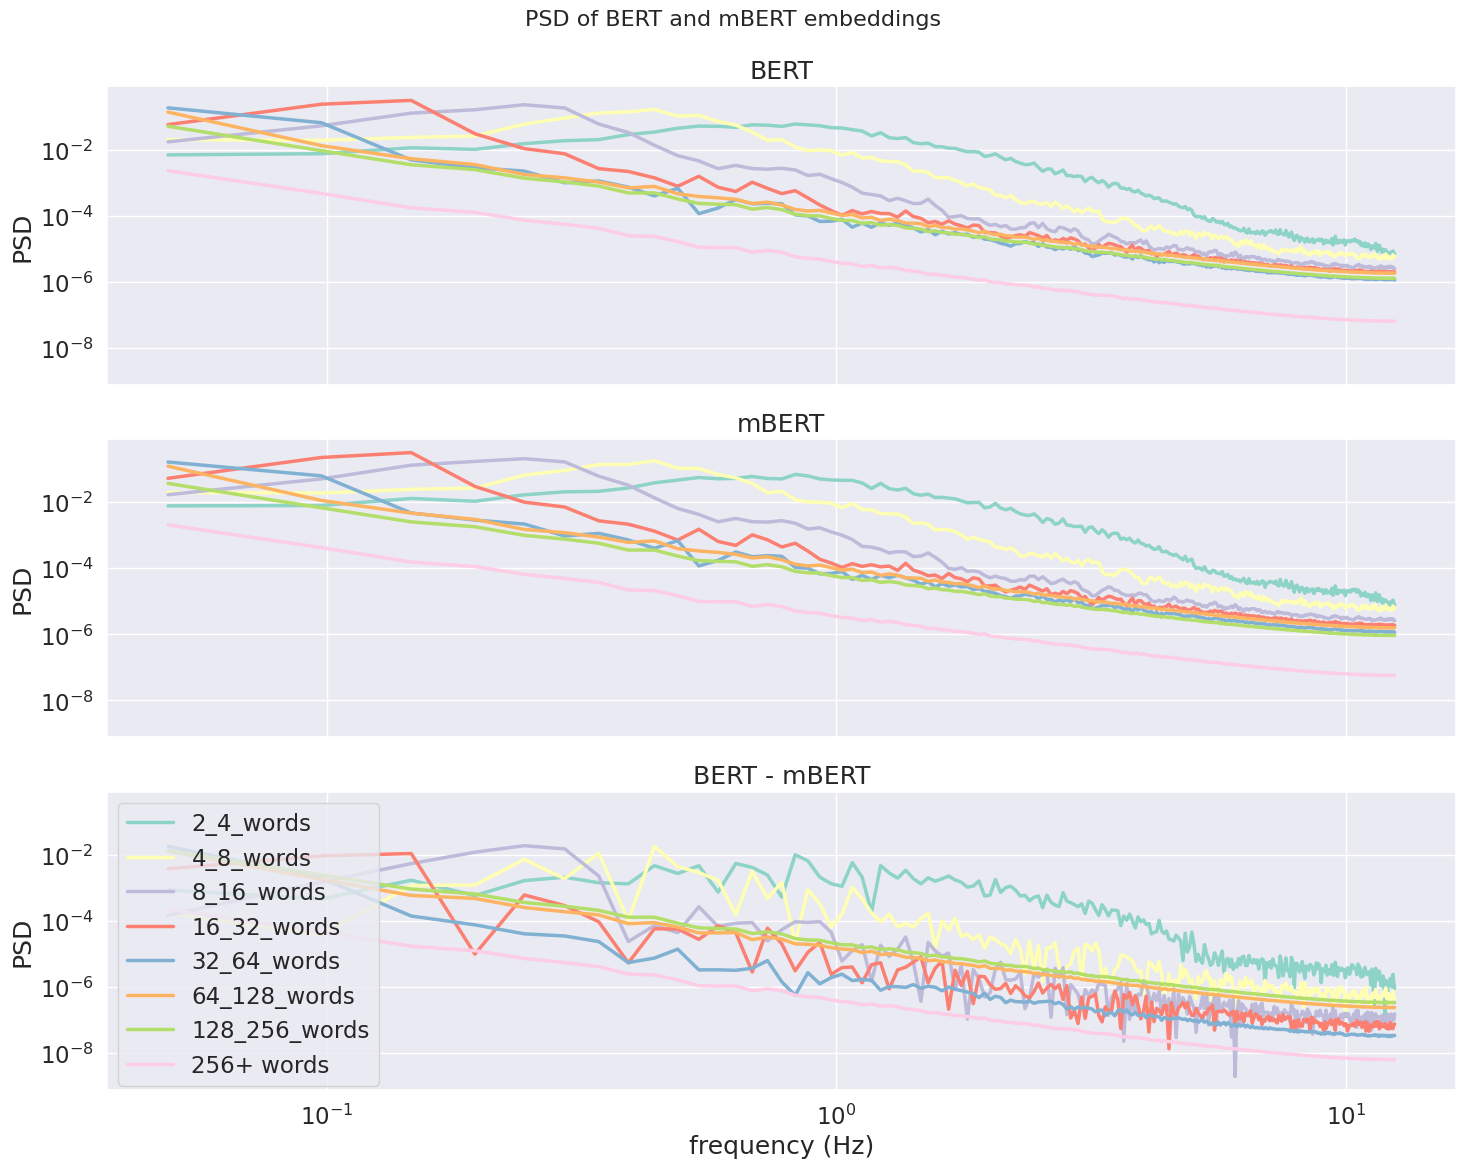

In [12]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharey=True, sharex=True)
axes = axes.ravel()

plot_psd(psd_bert, periods, ax=axes[0])
plot_psd(psd_mbert, periods, ax=axes[1])
plot_psd(diff_psd, periods, ax=axes[2])

axes[0].set_title("BERT")
axes[1].set_title("mBERT")
axes[2].set_title("BERT - mBERT")

fig.suptitle("PSD of BERT and mBERT embeddings", fontsize=16)

# log-scale
axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

# hide legends
axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

plt.tight_layout()
plt.show()


In [13]:
# Cross-Correlation Across Timescale Analysis

In [14]:
features

{'BERT': {'256+ words': array([[-0.38959772,  0.29294305, -0.24933406, ..., -0.0907011 ,
           0.16227554,  0.46983648],
         [-0.3895869 ,  0.29293938, -0.24933118, ..., -0.09070508,
           0.1622807 ,  0.46982351],
         [-0.38957609,  0.29293571, -0.2493283 , ..., -0.09070906,
           0.16228586,  0.46981055],
         ...,
         [-0.05496408,  0.18871242,  0.03556173, ..., -0.1860341 ,
           0.23196249, -0.05605995],
         [-0.05496173,  0.18871081,  0.03556285, ..., -0.1860204 ,
           0.23196459, -0.05605784],
         [-0.05495937,  0.1887092 ,  0.03556396, ..., -0.18600669,
           0.23196669, -0.05605573]]),
  '128_256_words': array([[-0.14494815,  0.09020603, -0.03249324, ...,  0.01011774,
           0.01805838,  0.04388982],
         [-0.1448783 ,  0.09015286, -0.03247495, ...,  0.01010426,
           0.01799234,  0.04390569],
         [-0.14480845,  0.0900997 , -0.03245666, ...,  0.01009078,
           0.01792631,  0.04392155],
         

In [15]:
# now concatenate feature into one 3d array
features_concat = {}

for lm in lms:
    arrays = []
    for p in periods:
        arr = features[lm][p]
        
        arrays.append(arr.T)
    # join by adding new axis
   
    features_concat[lm] =  np.vstack(arrays)

In [16]:
features_concat["BERT"].shape

(79872, 17375)